In [1]:
from __future__ import division
import numpy as np
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import graphlab
import scipy #to save mat files
import time  #to time code

In [2]:
#balanced accuracy
def Balanced_acc(ypred,ytest):
    acc_c = 0
    acc_class = np.zeros(5) #the accuracy per class
    for c in np.unique(ytest):
        i = ytest == c
        correct = ypred[i] == ytest[i]
        acc_c += sum(correct)/len(correct)
        acc_class[c] = sum(correct)/len(correct)

    Bacc = acc_c/len(np.unique(ytest))
    return Bacc,acc_class

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, ['Sit','StairsDw','StairsUp','Stand','Walk'], rotation=45)
    plt.yticks(tick_marks, ['Sit','StairsDw','StairsUp','Stand','Walk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def prec_rec(cmat):
    tpfp = cmat.sum(axis=1)
    tpfn = cmat.sum(axis=0)
    prec = cmat.diagonal()/tpfp
    recall = cmat.diagonal()/tpfn
    return prec,recall

### Load Data

In [3]:
HealthyData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/HealthyData.csv',verbose=False)
CBRData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/CBRData3Sess.csv',verbose=False)
SCOData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/SCOData3Sess.csv',verbose=False)

This non-commercial license of GraphLab Create for academic use is assigned to llonini@ricres.org and will expire on October 14, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\llonini\AppData\Local\Temp\graphlab_server_1476593799.log.0


In [4]:
HealthyCodes = HealthyData['SubjID'].unique()
HealthyCodes = HealthyCodes.sort()
HealthyCodes = HealthyCodes.to_numpy()
print HealthyCodes
PatientCodes = CBRData['SubjID'].unique()
PatientCodes = PatientCodes.sort()
PatientCodes = PatientCodes.to_numpy()
print PatientCodes

[51 52 53 54 55 56 57 58 59 60 61]
[ 1  2  5  6  8 11 14 15 16 19 24]


## Global Healthy model

In [12]:
col_names = HealthyData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

Xtrain = HealthyData.select_columns(feature_cols).to_numpy()
ytrain = HealthyData.select_columns(label_cols).to_numpy()
ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array

RF = RandomForestClassifier(n_estimators=10,random_state=0)
RF = RF.fit(Xtrain,ytrain)

#test on each patient (CBR)
SOacc = np.zeros(len(PatientCodes))
acc_class_subj = [] #accuracy per class for each subject
cmat_H = {} #store confusion mats, precision and recall for all subjects  
prec_H = {} 
recall_H ={}
k = 0

for s in PatientCodes:
    test = CBRData[(CBRData['SubjID'] == s)]
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1) #to squeeze last dimension and obtain a 1D array
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    print 'Test on Patient %s, Train samples=%s, Test samples=%s, Nclass test=%s'%(s,len(ytrain),len(ytest),Nclasses)
    ypred = RF.predict(Xtest)

    #acc = sum(ypred == ytest)/len(ytest)
    #SOacc[k] = acc

    #balanced accuracy
    SOacc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)  
    
    #confusion matrix
    cmat = confusion_matrix(ytest, ypred,labels=[0,1,2,3,4]) #labels=["Sit","Stairs Dw","Stairs Up","Stand","Walk"])
    prec,recall = prec_rec(cmat)
    #assemble data in dicts
    key = 'S'+np.array_str(np.array(s)) #subj code
    cmat_H.update({key:cmat})
    prec_H.update({s:prec})
    recall_H.update({s:recall})
    
    print 'BAcc = {:.2f}'.format(SOacc[k])
    k = k+1

print '\nmedian Bacc - Healthy model = %s'%np.median(SOacc)

#mean precision and recall per class
prec_H_mean = np.nanmean(np.asarray(prec_H.values()),axis=0)
rec_H_mean = np.nanmean(np.asarray(recall_H.values()),axis=0)
#acc_class_subj_mean = np.nanmean(acc_class_subj,axis=0)

Test on Patient 1, Train samples=8375, Test samples=1288, Nclass test=5
BAcc = 0.51
Test on Patient 2, Train samples=8375, Test samples=991, Nclass test=5
BAcc = 0.32
Test on Patient 5, Train samples=8375, Test samples=1358, Nclass test=5
BAcc = 0.42
Test on Patient 6, Train samples=8375, Test samples=2246, Nclass test=5
BAcc = 0.60
Test on Patient 8, Train samples=8375, Test samples=856, Nclass test=3
BAcc = 0.35
Test on Patient 11, Train samples=8375, Test samples=1207, Nclass test=5
BAcc = 0.50
Test on Patient 14, Train samples=8375, Test samples=1778, Nclass test=5
BAcc = 0.58
Test on Patient 15, Train samples=8375, Test samples=3177, Nclass test=5
BAcc = 0.46
Test on Patient 16, Train samples=8375, Test samples=1126, Nclass test=5
BAcc = 0.53
Test on Patient 19, Train samples=8375, Test samples=1020, Nclass test=3
BAcc = 0.59
Test on Patient 24, Train samples=8375, Test samples=1449, Nclass test=5
BAcc = 0.60

median Bacc - Healthy model = 0.506258192276


In [14]:
#save data
#save the dict to matlab format 
scipy.io.savemat('cmatHealthy',cmat_H)
np.savetxt('precisionHealthy.csv', prec_H_mean, delimiter=',') 
np.savetxt('recallHealthy.csv', rec_H_mean, delimiter=',') 

## Global model SCO (Leave one subject out)

In [11]:
ISpec_acc = np.zeros(len(PatientCodes)) 
Nsamples = np.zeros(len(PatientCodes))
acc_class_subj = [] #accuracy per class for each subject

cmat_ISpec = {} #store confusion mats, precision and recall for all subjects  
prec_ISpec = {} 
recall_ISpec ={}

k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] != s)]
    test = CBRData[(CBRData['SubjID'] == s)] 
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    Nsamples[k] = ytrain.shape[0]
    
    RF = RandomForestClassifier(n_estimators=10,random_state=0)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)

    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    ISpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)
    
    #confusion matrix
    cmat = confusion_matrix(ytest, ypred,labels=[0,1,2,3,4]) #labels=["Sit","Stairs Dw","Stairs Up","Stand","Walk"])
    prec,recall = prec_rec(cmat)
    #assemble data in dicts
    key = 'S'+np.array_str(np.array(s)) #subj code
    cmat_ISpec.update({key:cmat})
    prec_ISpec.update({s:prec})
    recall_ISpec.update({s:recall})

    print 'Patient {}, Nclass train = {}, Nclass test = {}, Nsamples train = {}, Global SCO - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,Nsamples[k],ISpec_acc[k])
    k = k+1

print 'Median BAcc - Impairment Specific (SCO) = %s'%np.median(ISpec_acc)
print 'Avg train size = {}'.format(np.mean(Nsamples))

#mean precision and recall per class
prec_ISpec_mean = np.nanmean(np.asarray(prec_ISpec.values()),axis=0)
rec_ISpec_mean = np.nanmean(np.asarray(recall_ISpec.values()),axis=0)

Patient 1, Nclass train = 5, Nclass test = 5, Nsamples train = 16679.0, Global SCO - BAcc = 0.57
Patient 2, Nclass train = 5, Nclass test = 5, Nsamples train = 16200.0, Global SCO - BAcc = 0.51


KeyboardInterrupt: 

In [16]:
#save the dict to matlab format 
scipy.io.savemat('cmatISpec',cmat_ISpec)
np.savetxt('precisionISpec.csv', prec_ISpec_mean, delimiter=',') 
np.savetxt('recallISpec.csv', rec_ISpec_mean, delimiter=',') 

## Global model CBR (Leave one subject out)

In [56]:
ISpecCBR_acc = np.zeros(len(PatientCodes))
Nsamples = np.zeros(len(PatientCodes))
acc_class_subj = [] #accuracy per class for each subject

cmat_ISpecCBR = {} #store confusion mats, precision and recall for all subjects  
prec_ISpecCBR = {} 
recall_ISpecCBR ={}

k = 0
for s in PatientCodes:
    
    train = CBRData[(CBRData['SubjID'] != s)]
    test = CBRData[(CBRData['SubjID'] == s)] #test on 3 CBR sessions
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    Nsamples[k] = ytrain.shape[0]

    RF = RandomForestClassifier(n_estimators=100,random_state=0)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    ISpecCBR_acc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)   
    
    #confusion matrix
    cmat = confusion_matrix(ytest, ypred,labels=[0,1,2,3,4]) #labels=["Sit","Stairs Dw","Stairs Up","Stand","Walk"])
    prec,recall = prec_rec(cmat)
    #assemble data in dicts
    key = 'S'+np.array_str(np.array(s)) #subj code
    cmat_ISpecCBR.update({key:cmat})
    prec_ISpecCBR.update({s:prec})
    recall_ISpecCBR.update({s:recall})

    print 'Patient {}, Nclass train = {}, Nclass test = {}, Nsamples train = {}, Global SCO - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,Nsamples[k],ISpecCBR_acc[k])
    k = k+1

print 'Median BAcc - Global CBR model = %s'%np.median(ISpecCBR_acc)
print 'Avg train size = {}'.format(np.mean(Nsamples))

#mean precision and recall per class
prec_ISpecCBR_mean = np.nanmean(np.asarray(prec_ISpecCBR.values()),axis=0)
rec_ISpecCBR_mean = np.nanmean(np.asarray(recall_ISpecCBR.values()),axis=0)

Patient 1, Nclass train = 5, Nclass test = 5, Nsamples train = 15208.0, Global SCO - BAcc = 0.63
Patient 2, Nclass train = 5, Nclass test = 5, Nsamples train = 15505.0, Global SCO - BAcc = 0.48
Patient 5, Nclass train = 5, Nclass test = 5, Nsamples train = 15138.0, Global SCO - BAcc = 0.52
Patient 6, Nclass train = 5, Nclass test = 5, Nsamples train = 14250.0, Global SCO - BAcc = 0.59
Patient 8, Nclass train = 5, Nclass test = 3, Nsamples train = 15640.0, Global SCO - BAcc = 0.62
Patient 11, Nclass train = 5, Nclass test = 5, Nsamples train = 15289.0, Global SCO - BAcc = 0.57
Patient 14, Nclass train = 5, Nclass test = 5, Nsamples train = 14718.0, Global SCO - BAcc = 0.60
Patient 15, Nclass train = 5, Nclass test = 5, Nsamples train = 13319.0, Global SCO - BAcc = 0.67
Patient 16, Nclass train = 5, Nclass test = 5, Nsamples train = 15370.0, Global SCO - BAcc = 0.59
Patient 19, Nclass train = 5, Nclass test = 3, Nsamples train = 15476.0, Global SCO - BAcc = 0.90
Patient 24, Nclass train 

In [58]:
#save the dict to matlab format 
scipy.io.savemat('cmatISpecCBR',cmat_ISpecCBR)
np.savetxt('precisionISpecCBR.csv', prec_ISpecCBR_mean, delimiter=',') 
np.savetxt('recallISpecCBR.csv', rec_ISpecCBR_mean, delimiter=',') 

## Personal SCO (Patient Specific model) 

In [17]:
PSpec_acc = np.zeros(len(PatientCodes)) 
Nsamples = np.zeros(len(PatientCodes))
acc_class_subj = [] #accuracy per class for each subject

cmat_PSpec = {} #store confusion mats, precision and recall for all subjects  
prec_PSpec = {} 
recall_PSpec ={}

k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] == s)]
    test = CBRData[(CBRData['SubjID'] == s)]
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    Nsamples[k] = ytrain.shape[0]

    RF = RandomForestClassifier(n_estimators=50,random_state=0)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    PSpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    
    #confusion matrix
    cmat = confusion_matrix(ytest, ypred,labels=[0,1,2,3,4]) #labels=["Sit","Stairs Dw","Stairs Up","Stand","Walk"])
    prec,recall = prec_rec(cmat)
    #assemble data in dicts
    key = 'S'+np.array_str(np.array(s)) #subj code
    cmat_PSpec.update({key:cmat})
    prec_PSpec.update({s:prec})
    recall_PSpec.update({s:recall})
    
    print 'Patient {}, Nclass train = {}, Nclass test = {},  Nsamples train = {}, Personal SCO - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,Nsamples[k],PSpec_acc[k])
    k = k+1

print 'Median BAcc - Patient Specific (SCO) = %s'%np.median(PSpec_acc)
print 'Avg train size = {}'.format(np.mean(Nsamples))

#mean precision and recall per class
prec_PSpec_mean = np.nanmean(np.asarray(prec_PSpec.values()),axis=0)
rec_PSpec_mean = np.nanmean(np.asarray(recall_PSpec.values()),axis=0)

Patient 1, Nclass train = 5, Nclass test = 5,  Nsamples train = 935.0, Personal SCO - BAcc = 0.72
Patient 2, Nclass train = 5, Nclass test = 5,  Nsamples train = 1414.0, Personal SCO - BAcc = 0.55
Patient 5, Nclass train = 5, Nclass test = 5,  Nsamples train = 2376.0, Personal SCO - BAcc = 0.65
Patient 6, Nclass train = 5, Nclass test = 5,  Nsamples train = 1076.0, Personal SCO - BAcc = 0.74
Patient 8, Nclass train = 5, Nclass test = 3,  Nsamples train = 2182.0, Personal SCO - BAcc = 0.69
Patient 11, Nclass train = 5, Nclass test = 5,  Nsamples train = 1636.0, Personal SCO - BAcc = 0.43
Patient 14, Nclass train = 5, Nclass test = 5,  Nsamples train = 1606.0, Personal SCO - BAcc = 0.48
Patient 15, Nclass train = 5, Nclass test = 5,  Nsamples train = 1863.0, Personal SCO - BAcc = 0.44
Patient 16, Nclass train = 5, Nclass test = 5,  Nsamples train = 2184.0, Personal SCO - BAcc = 0.46
Patient 19, Nclass train = 5, Nclass test = 3,  Nsamples train = 1255.0, Personal SCO - BAcc = 0.73
Patien

In [18]:
#save the dict to matlab format 
scipy.io.savemat('cmatPSpec',cmat_PSpec)
np.savetxt('precisionPSpec.csv', prec_PSpec_mean, delimiter=',') 
np.savetxt('recallPSpec.csv', rec_PSpec_mean, delimiter=',') 

## Personal CBR (Patient and Device specific model) 
Leave One Session Out 

In [19]:
DSpec_acc = np.zeros(len(PatientCodes)) 
Nsamples = np.zeros(len(PatientCodes))
Nsessions = 3

cmat_DSpec = {} #store confusion mats, precision and recall for all subjects  
prec_DSpec = {} 
recall_DSpec ={}
k = 0

for s in PatientCodes:
    cmat = np.zeros((5,5)) #temporary arrays to store cmat, prec and recall in each session
    prec = np.zeros(5)
    recall = np.zeros(5)

    data =  CBRData[(CBRData['SubjID'] == s)] 
    Bacc = np.zeros(Nsessions)
    for session in range(1,Nsessions+1):
                  
        test = data[data['Session'] == session]
        train = data[data['Session'] != session]
        Nclasstrain = len(train['Label'].unique())
        Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

        Xtrain = train.select_columns(feature_cols).to_numpy()
        ytrain = train.select_columns(label_cols).to_numpy()
        ytrain = ytrain.reshape(-1)
        Xtest = test.select_columns(feature_cols).to_numpy()
        ytest = test.select_columns(label_cols).to_numpy()
        ytest = ytest.reshape(-1)
        Nsamples[k] = Nsamples[k]+ytrain.shape[0]

        RF = RandomForestClassifier(n_estimators=50,random_state=0)
        RF = RF.fit(Xtrain,ytrain)
        ypred = RF.predict(Xtest)
        #acc = sum(ypred == ytest)/len(ytest)
        #balanced accuracy on each session
        Bacc[session-1],acc_class = Balanced_acc(ypred,ytest)
        print 'Nclass train = {}, Nclass test ={}, BAcc = {:.2f}'.format(Nclasstrain,Nclasses,Bacc[session-1])
        
        #confusion matrix, prec and recall in each session
        cmat_tmp = confusion_matrix(ytest,ypred,labels=[0,1,2,3,4]) #labels=["Sit","Stairs Dw","Stairs Up","Stand","Walk"])
        cmat += cmat_tmp
        pr,re = prec_rec(cmat_tmp)
        prec += pr
        recall += re

    DSpec_acc[k] = Bacc.mean() #the CV BAcc on 3 sessions 
    Nsamples[k] = Nsamples[k]/len(range(1,Nsessions+1)) #mean number of samples across sessions    
    #mean confusion matrix (instances), precision and recall on 3 sessions
    avgcmat = cmat/Nsessions
    prec = prec/Nsessions
    recall = recall/Nsessions

    #assemble data in dicts
    key = 'S'+np.array_str(np.array(s)) #subj code
    cmat_DSpec.update({key:avgcmat})     #the confusion matrix with instances from the 4 sessions
    prec_DSpec.update({s:prec})
    recall_DSpec.update({s:recall})
   
    print 'Patient {}, Device Specific model - BAcc = {:.2f}'.format(s,DSpec_acc[k])
    k = k+1

print 'Median BAcc - Device Specific (CBR) = %s'%(np.median(DSpec_acc))
print 'Avg train size = {}'.format(np.mean(Nsamples))

#mean precision and recall per class
prec_DSpec_mean = np.nanmean(np.asarray(prec_DSpec.values()),axis=0)
rec_DSpec_mean = np.nanmean(np.asarray(recall_DSpec.values()),axis=0)

Nclass train = 5, Nclass test =5, BAcc = 0.77
Nclass train = 5, Nclass test =5, BAcc = 0.82
Nclass train = 5, Nclass test =5, BAcc = 0.87
Patient 1, Device Specific model - BAcc = 0.82
Nclass train = 5, Nclass test =5, BAcc = 0.76
Nclass train = 5, Nclass test =5, BAcc = 0.51
Nclass train = 5, Nclass test =5, BAcc = 0.73
Patient 2, Device Specific model - BAcc = 0.67
Nclass train = 5, Nclass test =5, BAcc = 0.78
Nclass train = 5, Nclass test =5, BAcc = 0.55
Nclass train = 5, Nclass test =5, BAcc = 0.59
Patient 5, Device Specific model - BAcc = 0.64
Nclass train = 5, Nclass test =5, BAcc = 0.61
Nclass train = 5, Nclass test =5, BAcc = 0.75
Nclass train = 5, Nclass test =5, BAcc = 0.84
Patient 6, Device Specific model - BAcc = 0.73
Nclass train = 3, Nclass test =3, BAcc = 0.93
Nclass train = 3, Nclass test =3, BAcc = 0.70
Nclass train = 3, Nclass test =3, BAcc = 0.97
Patient 8, Device Specific model - BAcc = 0.87
Nclass train = 5, Nclass test =5, BAcc = 0.41
Nclass train = 5, Nclass test

In [20]:
#save the dict to matlab format 
scipy.io.savemat('cmatDSpec',cmat_DSpec)
np.savetxt('precisionDSpec.csv', prec_DSpec_mean, delimiter=',') 
np.savetxt('recallDSpec.csv', rec_DSpec_mean, delimiter=',') 

## Assemble results for all models

In [21]:
acc_all=np.vstack((SOacc,ISpec_acc,ISpecCBR_acc,PSpec_acc,DSpec_acc)).T
print acc_all

NameError: name 'ISpecCBR_acc' is not defined

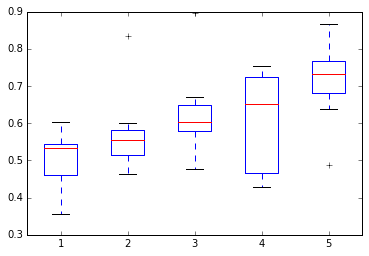

In [85]:
plt.boxplot(acc_all)
plt.show()

In [86]:
np.median(SOacc)

0.53400055983576222

In [87]:
np.median(ISpec_acc)

0.55567333631468108

In [72]:
np.median(ISpecCBR_acc)

0.6021543467550432

In [68]:
np.median(PSpec_acc)

0.65157867467006247

In [69]:
np.median(DSpec_acc)

0.73244102027087032

In [123]:
np.savetxt('results.csv', acc_all, delimiter=',') 

## Try Gradient Boosting

In [75]:
from sklearn.ensemble import GradientBoostingClassifier

In [79]:
col_names = HealthyData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

Xtrain = HealthyData.select_columns(feature_cols).to_numpy()
ytrain = HealthyData.select_columns(label_cols).to_numpy()
ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array

clf = GradientBoostingClassifier(n_estimators=100,random_state=0)
clf = clf.fit(Xtrain,ytrain)

#test on each patient (CBR)
SOacc = np.zeros(len(PatientCodes))
acc_class_subj = [] #accuracy per class for each subject
cmat_H = {} #store confusion mats, precision and recall for all subjects  
prec_H = {} 
recall_H ={}
k = 0

for s in PatientCodes:
    test = CBRData[(CBRData['SubjID'] == s)]
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1) #to squeeze last dimension and obtain a 1D array
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    print 'Test on Patient %s, Train samples=%s, Test samples=%s, Nclass test=%s'%(s,len(ytrain),len(ytest),Nclasses)
    ypred = clf.predict(Xtest)

    #acc = sum(ypred == ytest)/len(ytest)
    #SOacc[k] = acc

    #balanced accuracy
    SOacc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)  
    
    #confusion matrix
    cmat = confusion_matrix(ytest, ypred,labels=[0,1,2,3,4]) #labels=["Sit","Stairs Dw","Stairs Up","Stand","Walk"])
    prec,recall = prec_rec(cmat)
    #assemble data in dicts
    key = 'S'+np.array_str(np.array(s)) #subj code
    cmat_H.update({key:cmat})
    prec_H.update({s:prec})
    recall_H.update({s:recall})
    
    print 'BAcc = {:.2f}'.format(SOacc[k])
    k = k+1

print '\nmedian Bacc - Healthy model = %s'%np.median(SOacc)

#mean precision and recall per class
prec_H_mean = np.nanmean(np.asarray(prec_H.values()),axis=0)
rec_H_mean = np.nanmean(np.asarray(recall_H.values()),axis=0)
#acc_class_subj_mean = np.nanmean(acc_class_subj,axis=0)

Test on Patient 1, Train samples=8375, Test samples=1288, Nclass test=5
BAcc = 0.52
Test on Patient 2, Train samples=8375, Test samples=991, Nclass test=5
BAcc = 0.39
Test on Patient 5, Train samples=8375, Test samples=1358, Nclass test=5
BAcc = 0.45
Test on Patient 6, Train samples=8375, Test samples=2246, Nclass test=5
BAcc = 0.60
Test on Patient 8, Train samples=8375, Test samples=856, Nclass test=3
BAcc = 0.36
Test on Patient 11, Train samples=8375, Test samples=1207, Nclass test=5
BAcc = 0.52
Test on Patient 14, Train samples=8375, Test samples=1778, Nclass test=5
BAcc = 0.53
Test on Patient 15, Train samples=8375, Test samples=3177, Nclass test=5
BAcc = 0.48
Test on Patient 16, Train samples=8375, Test samples=1126, Nclass test=5
BAcc = 0.53
Test on Patient 19, Train samples=8375, Test samples=1020, Nclass test=3
BAcc = 0.64
Test on Patient 24, Train samples=8375, Test samples=1449, Nclass test=5
BAcc = 0.64

median Bacc - Healthy model = 0.519083682588


## Global model simulations
Train on increasing number of healthy subjects (from 1 to 11) and test on 1 CBR patient. Run Nruns times by randomzing subjects in each run

* Healthy model

In [5]:
col_names = HealthyData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

Nruns = 1000 #total # of runs
Ntrain = len(HealthyData['SubjID'].unique()) #the total number of healthy to train on
Bacc_all = np.zeros((Nruns,Ntrain)) #contains the Bacc for each run 

t0 = time.time()
#loop through num subj to train on
for n in range(Ntrain):
    print 'train on {} subjects'.format(n+1)
    for run in range(1,Nruns+1):
        if run%100 == 0:
            print 'run={}/{}'.format(run,Nruns)       
        #pick n subj to train 
        np.random.shuffle(HealthyCodes)
        subjtrain = HealthyCodes[0:n+1]
        train = HealthyData.filter_by(subjtrain,'SubjID')
        test = np.random.shuffle(PatientCodes)
        subjtest = PatientCodes[0] #pick one subj to test
        test = CBRData.filter_by(subjtest,'SubjID')
        #print 'Run=%s, Train on subj %s, test on patient %s'%(run,train['SubjID'].unique(),test['SubjID'].unique())

        Xtrain = train.select_columns(feature_cols).to_numpy()
        ytrain = train.select_columns(label_cols).to_numpy()
        ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array
        Xtest = test.select_columns(feature_cols).to_numpy()
        ytest = test.select_columns(label_cols).to_numpy()
        ytest = ytest.reshape(-1)

        RF = RandomForestClassifier(n_estimators=10)
        RF = RF.fit(Xtrain,ytrain)
        ypred = RF.predict(Xtest)

        #acc = sum(ypred == ytest)/len(ytest)
        #balanced accuracy for current run
        Bacc_all[run-1,n],acc_class = Balanced_acc(ypred,ytest)
        #print 'Bacc = {:.2f}'.format(Bacc_all[run,n])

t1 = time.time()
print 'Elapsed time=%.2f secs'%(t1-t0)

train on 1 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 2 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 3 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 4 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 5 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 6 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 7 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1

In [6]:
np.savetxt('results_GlobalH.csv', Bacc_all, delimiter=',') 

* Global SCO Model simulations

In [7]:
col_names = SCOData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

Nruns = 1000 #total # of runs
Ntrain = len(SCOData['SubjID'].unique()) #the total number of patients (SCO)
Bacc_all = np.zeros((Nruns,Ntrain-1)) #contains the Bacc for each run 

t0 = time.time()
#loop through num subj to train on
for n in range(Ntrain-1): #-1 as one patient is out for test
    print 'train on {} subjects'.format(n+1)
    for run in range(1,Nruns+1):
        if run%100 == 0:
            print 'run={}/{}'.format(run,Nruns)       
        #pick n subj to train (use last for test)
        np.random.shuffle(PatientCodes)
        subjtrain = PatientCodes[0:n+1]
        train = SCOData.filter_by(subjtrain,'SubjID')
        subjtest = PatientCodes[n+1] #pick one patient to test (the last, not in train)
        test = CBRData.filter_by(subjtest,'SubjID')
        #print 'Run=%s, Train on subj %s, test on patient %s'%(run,train['SubjID'].unique(),test['SubjID'].unique())

        Xtrain = train.select_columns(feature_cols).to_numpy()
        ytrain = train.select_columns(label_cols).to_numpy()
        ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array
        Xtest = test.select_columns(feature_cols).to_numpy()
        ytest = test.select_columns(label_cols).to_numpy()
        ytest = ytest.reshape(-1)

        RF = RandomForestClassifier(n_estimators=10)
        RF = RF.fit(Xtrain,ytrain)
        ypred = RF.predict(Xtest)

        #acc = sum(ypred == ytest)/len(ytest)
        #balanced accuracy for current run
        Bacc_all[run-1,n],acc_class = Balanced_acc(ypred,ytest)
        #print 'Bacc = {:.2f}'.format(Bacc_all[run-1,n])
t1 = time.time()
print 'Elapsed time=%.2f secs'%(t1-t0)

train on 1 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 2 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 3 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 4 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 5 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 6 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 7 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1

In [8]:
np.savetxt('results_GlobalP.csv', Bacc_all, delimiter=',') 

* Global CBR Simulations

In [5]:
col_names = CBRData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

Nruns = 1000 #total # of runs
Ntrain = len(CBRData['SubjID'].unique()) #the total number of patients (CBR)
Bacc_all = np.zeros((Nruns,Ntrain-1)) #contains the Bacc for each run 

t0 = time.time()
#loop through num subj to train on
for n in range(Ntrain-1): #-1 as one patient is out for test
    print 'train on {} subjects'.format(n+1)
    for run in range(1,Nruns+1):
        if run%100 == 0:
            print 'run={}/{}'.format(run,Nruns)       
        #pick n subj to train (use last for test)
        np.random.shuffle(PatientCodes)
        subjtrain = PatientCodes[0:n+1]
        train = CBRData.filter_by(subjtrain,'SubjID')
        subjtest = PatientCodes[n+1] #pick one patient to test (the last, not in train)
        test = CBRData.filter_by(subjtest,'SubjID')
        #print 'Run=%s, Train on subj %s, test on patient %s'%(run,train['SubjID'].unique(),test['SubjID'].unique())

        Xtrain = train.select_columns(feature_cols).to_numpy()
        ytrain = train.select_columns(label_cols).to_numpy()
        ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array
        Xtest = test.select_columns(feature_cols).to_numpy()
        ytest = test.select_columns(label_cols).to_numpy()
        ytest = ytest.reshape(-1)

        RF = RandomForestClassifier(n_estimators=50,n_jobs=-1)
        RF = RF.fit(Xtrain,ytrain)
        ypred = RF.predict(Xtest)

        #acc = sum(ypred == ytest)/len(ytest)
        #balanced accuracy for current run
        Bacc_all[run-1,n],acc_class = Balanced_acc(ypred,ytest)
        #print 'Bacc = {:.2f}'.format(Bacc_all[run-1,n])
t1 = time.time()
print 'Elapsed time=%.2f secs'%(t1-t0)

train on 1 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 2 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 3 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 4 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 5 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 6 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 7 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1

In [6]:
np.savetxt('results_GlobalP_CBR.csv', Bacc_all, delimiter=',') 